# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Build and submit a scikit-learn pipeline having neural network regressor as the model.
- Build and submit a scikit-learn pipeline having gradient boosted regressor as the model.
- Build and submit a xgboost model.
- Achieve a score better than 0.13 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score.
- How simple is the model.
- How fast is the model prediction.
- Code quality.

# Imports

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set_theme()
import xgboost as xgb
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from functions import articial_features

# Data preparation

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#msno.bar(train_data, labels=True, fontsize=12);

## Data cleaning

In [5]:
features_to_drop = ["Id"]

cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

# Modelling

In [6]:
target = "SalePrice"

# Data used for cross-validation.
X_cv = cleaned_train_data.drop(columns=target)
y_cv = np.log(cleaned_train_data[target])

# Data used for training.
X_train = cleaned_train_data.drop(columns=target)
y_train = cleaned_train_data[target]

## Baseline models

In [7]:
cat_transformer_base = Pipeline(
    steps=[
        ("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="None")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

In [8]:
preprocessor_base = ColumnTransformer(
    transformers=[
        ("num_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent"), make_column_selector(dtype_include=np.number)),
        ("cat_transformer", cat_transformer_base, make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

### Neural network

In [9]:
nnet_base = MLPRegressor(
    hidden_layer_sizes=(150,150,150),
    max_iter=500
    )

In [10]:
nnet_base_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_base),
        ("model", nnet_base)
    ]
)

In [11]:
nnet_base_scores = cross_val_score(nnet_base_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(nnet_base_scores.mean())

9.769206432959088

In [12]:
%%time

nnet_base_pipeline.fit(X_train, y_train)

nnet_base_predictions = nnet_base_pipeline.predict(cleaned_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": nnet_base_predictions})
output.to_csv("submissions/nnet_base_predictions.csv", index=False)

Wall time: 17.1 s


### Gradient Boosting regressor

In [13]:
gbr_base = GradientBoostingRegressor(random_state=42)

In [14]:
gbr_base_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_base),
        ("model", gbr_base)
    ]
)

In [15]:
gbr_base_scores = cross_val_score(gbr_base_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(gbr_base_scores.mean())

0.12684985807317195

In [16]:
%%time

gbr_base_pipeline.fit(X_train, y_train)

gbr_base_predictions = gbr_base_pipeline.predict(cleaned_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": gbr_base_predictions})
output.to_csv("submissions/gbr_base_predictions.csv", index=False)

Wall time: 823 ms


### XGBoost regressor

In [17]:
xgb_base = xgb.XGBRegressor()

In [18]:
xgb_base_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_base),
        ("model", xgb_base)
    ]
)

In [19]:
xgb_base_scores = cross_val_score(xgb_base_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(xgb_base_scores.mean())

0.13785810399798426

In [20]:
%%time

xgb_base_pipeline.fit(X_train, y_train)

xgb_base_predictions = xgb_base_pipeline.predict(cleaned_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": xgb_base_predictions})
output.to_csv("submissions/xgb_base_predictions.csv", index=False)

Wall time: 632 ms


## Main models

Some features have very skewed distribution and their values are somewhat similar. For example "Functional" column has two distinct values Min1 and Min2 which both are related to Minor Deductions, so I have decided to merge them.

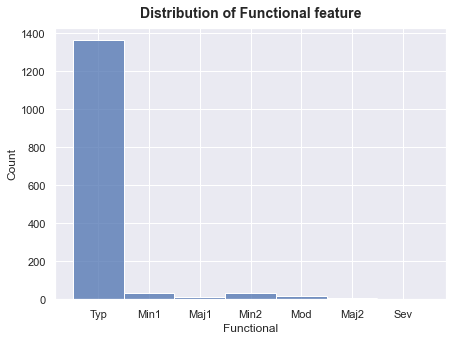

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(ax=ax, data=cleaned_train_data, x="Functional")
plt.title("Distribution of Functional feature", fontsize=14, fontweight="bold", pad=10);

In [22]:
def merger(input_df: pd.DataFrame) -> pd.DataFrame:
    
    input_df["Functional"] = input_df["Functional"].replace(["Min1", "Min2"], "Min")
    input_df["LandContour"] = input_df["LandContour"].replace("Lvl", "Flat")
    input_df["LandContour"] = input_df["LandContour"].replace(["Bnk", "HLS", "Low"], "NotFlat")
    input_df["Condition1"] = input_df["Condition1"].replace(["RRAn", "RRAe", "RRNn", "RRNe"], "RR")
    input_df["Exterior2nd"] = input_df["Exterior2nd"].replace(["CmentBd", "HdBoard"], "Board")
    input_df["SaleType"] = input_df["SaleType"].replace(["ConLw", "ConLD", "ConLI"], "Con")
    
    return input_df

In [23]:
get_merger = FunctionTransformer(merger)

In [24]:
# Variables for artificial_features function.
sqrt_features = ["GrLivArea", "TotalBsmtSF", "LotArea", "1stFlrSF", "2ndFlrSF", "MasVnrArea"]
area_features = ["TotalBsmtSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch"]

get_artificial_features = FunctionTransformer(articial_features, kw_args={"sqrt_features": sqrt_features, "area_features": area_features})

In [25]:
num_transformer = Pipeline(
    steps=[
        ("num_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent"))
    ]
)

In [26]:
cat_transformer = Pipeline(
    steps=[
        ("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="None")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_transformer", num_transformer, make_column_selector(dtype_include=np.number)),
        ("cat_transformer", cat_transformer, make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
)

### Neural network

In [28]:
nnet = MLPRegressor(
    )

In [29]:
nnet_pipeline = Pipeline(
    steps=[
        ("artificial", get_artificial_features),
        ("preprocessor", preprocessor),
        ("model", nnet)
    ]
)

In [30]:
params = {"model__hidden_layer_sizes": [(150,150,150,150), (200,200,200,200), (200,200,200,200,200)],
          "model__solver": ["lbfgs", "adam"],
          "model__max_iter": [750, 1000]}

In [ ]:
empty

In [ ]:
randomized_search = RandomizedSearchCV(estimator=nnet_pipeline, param_distributions=params, n_iter=100, scoring="neg_root_mean_squared_error")
randomized_search.fit(X_cv, y_cv)

In [32]:
best_params = randomized_search.best_params_

In [33]:
best_params

{'model__solver': 'adam',
 'model__max_iter': 750,
 'model__hidden_layer_sizes': (200, 200, 200, 200)}

In [46]:
nnet_scores = cross_val_score(nnet_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(nnet_scores.mean())

25.873218752658556

In [ ]:
%%time

nnet_pipeline.fit(X_train, y_train)

nnet_predictions = nnet_pipeline.predict(cleaned_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": nnet_predictions})
output.to_csv("submissions/nnet_predictions.csv", index=False)

Wall time: 4.81 s


### Gradient Boosting regressor

In [71]:
gbr = GradientBoostingRegressor(random_state=42)

In [119]:
gbr_selector = SelectFromModel(estimator=gbr, threshold="0.25*mean")

In [120]:
gbr_pipeline = Pipeline(
    steps=[
        ("merger", get_merger),
        ("artificial", get_artificial_features),
        ("preprocessor", preprocessor),
        ("selector", gbr_selector),
        ("model", gbr)
    ]
)

In [121]:
gbr_scores = cross_val_score(gbr_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(gbr_scores.mean())

0.12430177392339263

In [112]:
%%time

gbr_pipeline.fit(X_train, y_train)

gbr_predictions = gbr_pipeline.predict(cleaned_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": gbr_predictions})
output.to_csv("submissions/gbr_predictions.csv", index=False)

Wall time: 1.26 s


### XGBoost regressor

In [113]:
xgboost = xgb.XGBRegressor()

In [158]:
xgb_pipeline = Pipeline(
    steps=[
        ("merger", get_merger),
        ("artificial", get_artificial_features),
        ("preprocessor", preprocessor),
        ("model", xgboost)
    ]
)

In [159]:
xgb_scores = cross_val_score(xgb_pipeline, X_cv, y_cv, scoring="neg_root_mean_squared_error", error_score="raise")
abs(xgb_scores.mean())

0.1364212721688444

In [160]:
%%time

xgb_pipeline.fit(X_train, y_train)

xgb_predictions = xgb_pipeline.predict(cleaned_test_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": xgb_predictions})
output.to_csv("submissions/xgb_predictions.csv", index=False)

Wall time: 496 ms


# Scores

In [123]:
nnet_base_score = 4.48801
gbr_base_score = 0.12685
xgboost_base_score = 0.13786

nnet_score = 36.06910
gbr_score = 0.12430
xgboost_score = 0.13523

kaggle_nnet_base_score = 0.16534
kaggle_gbr_base_score = 0.13611
kaggle_xgboost_base_score = 0.14542

kaggle_nnet_score = 0.15896
kaggle_gbr_score = 0.13185
kaggle_xgboost_score = 0.13327

scores_table = pd.DataFrame({"Base Score": [nnet_base_score, gbr_base_score, xgboost_base_score],
                             "Score": [nnet_score, gbr_score, xgboost_score],
                             "Kaggle Base Score": [kaggle_nnet_base_score, kaggle_gbr_base_score, kaggle_xgboost_base_score],
                             "Kaggle Score": [kaggle_nnet_score, kaggle_gbr_score, kaggle_xgboost_score],
                             "Real-Time Score": [round(abs(nnet_scores.mean()), 5), round(abs(gbr_scores.mean()), 5), round(abs(xgb_scores.mean()), 5)]
                             }
                            ).set_axis(
                                 ["Neural Network", "Gradient Boosting", "XGBoost"], axis="index"
                                 )
                             
scores_table

,Base Score,Score,Kaggle Base Score,Kaggle Score,Real-Time Score
Neural Network,4.48801,36.06910,0.16534,0.15896,25.87322
Gradient Boosting,0.12685,0.12430,0.13611,0.13185,0.12430
XGBoost,0.13786,0.13523,0.14542,0.13327,0.13523


# Fails

### Things which didn't have any improvements to final score:

- Merger for Neural network
- PolynomialFeatures
- SelectFromModel for XGBoost